# Capstone project - Finding the best location for a new hotel in Amsterdam

### Gijs Hendrix - IBM Data Science Certificate Capstone project

<br>

## Introduction

### Background and problem

I want to open a new hotel in Amsterdam, my hometown. It historic centre, museums, restaurants and bars attract a large amount of tourist from both The Netherlands as abroad. As a 30-something-year old myself I will look for locations that would fit a tourist like myself. My interests include restaurants and bars and in this study I will focus on these. Additionally I want to make sure my hotel is unique and attracts customers.

Therefore there are two criteria I will use to select the location:
- Location versus competition. As the hotel market in Amsterdam is rather saturated I want to make sure to find a location without much competition.
- Vicinity to restaurants and bars. While the city is rather small and accessible my hotel needs to have a lot of restaurants and bars within walking distance.


### Audience

The target audience is (potential) investors in hotels or existing hotel chains. This report will provide them with options for neighborhoods to open a new hotel in.

## Data

### Data sources

In order to answer the problem posed before I need data on the current hotel market in Amsterdam as well as information on restaurants and bars. After searching online I found two data sources that fulfill my requirements:Foursquare data on restaurants and bars and datasets from the city of Amsterdam, found on the following location: https://data.amsterdam.nl/. I found two sets:
- https://data.amsterdam.nl/datasets/smyIEaiLR6uRlg/.  The dataset contains information on hotels within Amsterdam (name, address, star rating, amount of rooms and amount of beds). The data is unfortunately from 2014. I was not able to find a newer dataset. While in a real-life case a newer dataset might be required for this project I will continue with this one.
- https://data.amsterdam.nl/data/bag/adressen/?modus=volledig. This set also contains geographical data such as latitude and longitude.


### Data loading and cleaning

In order to use the data I import and use several libraries for this analysis:
- Pandas
- Matplotlib
- Seaborn
- Folium
- Requests
- Json and JSON normalize
- Numpy

In [49]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
!conda install -c conda-forge folium=0.5.0 --yes
import folium
!conda install -c conda-forge geopy --yes 
import requests
import json
from pandas.io.json import json_normalize
import numpy as np

Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::anaconda==5.3.1=py37_0
  - defaults/linux-64::astropy==3.0.4=py37h14c3975_0
  - defaults/linux-64::bkcharts==0.2=py37_0
  - defaults/linux-64::blaze==0.11.3=py37_0
  - defaults/linux-64::bokeh==0.13.0=py37_0
  - defaults/linux-64::bottleneck==1.2.1=py37h035aef0_1
  - defaults/linux-64::dask==0.19.1=py37_0
  - defaults/linux-64::datashape==0.5.4=py37_1
  - defaults/linux-64::mkl-service==1.1.2=py37h90e4bf4_5
  - defaults/linux-64::numba==0.39.0=py37h04863e7_0
  - defaults/linux-64::numexpr==2.6.8=py37hd89afb7_0
  - defaults/linux-64::odo==0.5.1=py37_0
  - defaults/linux-64::pytables==3.4.4=py37ha205bf6_0
  - defaults/linux-64::pytest-arraydiff==0.2=py37h39e3cac_0
  - defaults/linux-64::pytest-astropy==0.4.0=py37_0
  - defaults/linux-64::pytest-doctestplus==0.1.3=py37_0
  - defaults/linux-64::pywavelets==1.0.0=py37h

Now I will import the City of Amsterdam dataset on hotels:

In [22]:
filename = "https://api.data.amsterdam.nl/dcatd/datasets/smyIEaiLR6uRlg/purls/sSHb6wY8s7KynQ"
hotels = pd.read_excel(filename)

Let's see how the dataset looks like:

In [23]:
hotels.tail()

,HOTELNAAM_2014,NHC_2014,KAM_2014,BED_2014,STRAAT_2014,HUISID_2014,POSTCODE_2014,BRTK10,unesco,Soort_hotel_hostel/ jeugdherberg
417,B&B Apostrophe,0,3,6,Geerdinkhof,258,1103RA,T94j,NaN,"B&B, pension, appartamenten, guesthouse, boere..."
418,Hampton by Hilton Amsterdam Arena Boulevard,3,260,520,Hoekenrode,1,1102BR,T93e,NaN,hotel
419,Reijgersbroeck Bed & Breakfast,0,4,8,Provincialeweg,30,1108AB,T95b,NaN,"B&B, pension, appartamenten, guesthouse, boere..."
420,Brooklyn hotel,4,88,160,NDSM - Plein,28,1033WB,N71d,NaN,hotel
421,totaal,421 hotels,26287,56718,NaN,NaN,NaN,NaN,NaN,NaN


The last column seems to have pretty long descriptions of the kind of hotel. Let's simplify.
The last row is not needed and can be deleted.

In [24]:
hotels = hotels.replace({'Soort_hotel_hostel/ jeugdherberg': {'hostel/ jeugdherberg':'hostel', 'B&B, pension, appartamenten, guesthouse, boerenkamer': 'Other'}})
hotels.drop(hotels.index[421], inplace=True)

Let's see some descriptive statistics for the amount of rooms (KAM_2014) and beds (BED_2014)

In [25]:
hotels.describe()

,KAM_2014,BED_2014
count,421.000000,421.000000
mean,62.439430,134.722090
std,91.568082,188.811915
min,2.000000,5.000000
25%,13.000000,28.000000
50%,27.000000,65.000000
75%,67.000000,140.000000
max,610.000000,1220.000000


Let's find out how many items we have per category of hotel:

In [26]:
hotels['Soort_hotel_hostel/ jeugdherberg'].value_counts()

hotel     362
Other      39
hostel     20
Name: Soort_hotel_hostel/ jeugdherberg, dtype: int64

Most of the items are classified as hotel. There are some hostels as well as other instances.

The column BED_2014 shows the amount of beds in the hotel. I want to understand the diversity in size of the current hotels and will plot a scatterplot to show the spread:

[Text(0.5, 0, 'Kind of hotel')]

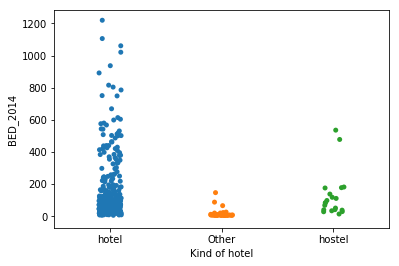

In [27]:
sns.stripplot(x="Soort_hotel_hostel/ jeugdherberg", y="BED_2014", data=hotels).set(xlabel="Kind of hotel")

The plot shows several things:
- Hotels come in many sizes. There seems to be a large concentration of hotels with between 0 and 200 beds.
- Other all score below 200 beds. All rather small it seems.
- Hostel shows most items between 50 and 200 beds, and two outliers of around 500-600.

Let's dive into the numbers, the average per category:

In [28]:
hotels.groupby(['Soort_hotel_hostel/ jeugdherberg'],as_index= False).mean()

,Soort_hotel_hostel/ jeugdherberg,KAM_2014,BED_2014
0,Other,6.743590,16.076923
1,hostel,22.450000,126.250000
2,hotel,70.649171,147.972376


So the average hotel has around 150 beds, the average hostel around 126 and the average other around 16.

### Adding geographical data

The hotels dataset unfortunately does not contain geographical data. I do want this in order to plot the data on a map. The City of Amsterdam luckily also has a table online including this data. I will now import this database and add the geographical data to the hotels dataframe. I will use the postalcode to link the two tables. The dataset is downloaded from the website and imported in my IBM Jupyter environment by hand.

In [29]:
file = "export_20190610_170948.csv"
geo_data = pd.read_csv(file, error_bad_lines=False, delimiter=";", decimal=",")
geo_data.head()

,Naam openbare ruimte,Huisnummer,Huisletter,Huisnummertoevoeging,Postcode,Woonplaats,Naam stadsdeel,Code stadsdeel,Naam gebiedsgerichtwerkengebied,Code gebiedsgerichtwerkengebied,...,Feitelijk gebruik,Oppervlakte (m2),Objecttype,Verblijfsobjectstatus,Openbareruimte-identificatie,Pandidentificatie,Verblijfsobjectidentificatie,Ligplaatsidentificatie,Standplaatsidentificatie,Nummeraanduidingidentificatie
0,Eerste Lindendwarsstraat,11,NaN,3,1015LE,NaN,Centrum,A,Centrum-West,DX01,...,woning,38.0,Verblijfsobject,Verblijfsobject in gebruik,363300000002551,0363100012172852,3.630100e+14,NaN,NaN,363200000010308
1,Eerste Anjeliersdwarsstraat,35,NaN,NaN,1015NR,NaN,Centrum,A,Centrum-West,DX01,...,woning,46.0,Verblijfsobject,Verblijfsobject in gebruik,363300000002529,0363100012174783,3.630100e+14,NaN,NaN,363200000006139
2,Eerste Anjeliersdwarsstraat,1,NaN,2,1015NR,NaN,Centrum,A,Centrum-West,DX01,...,woning,48.0,Verblijfsobject,Verblijfsobject in gebruik,363300000002529,0363100012174784,3.630100e+14,NaN,NaN,363200000006112
3,Eerste Constantijn Huygensstraat,45,NaN,2,1054BS,NaN,West,E,Oud West / De Baarsjes,DX05,...,woning,58.0,Verblijfsobject,Verblijfsobject in gebruik,363300000002537,0363100012164501,3.630100e+14,NaN,NaN,363200000007104
4,Eerste Jan van der Heijdenstraat,46,NaN,1,1072TW,NaN,Zuid,K,De Pijp / Rivierenbuurt,DX12,...,woning,68.0,Verblijfsobject,Verblijfsobject in gebruik,363300000002545,0363100012164826,3.630100e+14,NaN,NaN,363200000009377


Let's clean up the dataframe and remove unncessary columns

In [30]:
geo_data = geo_data.drop(["Woonplaats", "Naam stadsdeel",
       "Code stadsdeel", "Naam gebiedsgerichtwerkengebied",
       "Code gebiedsgerichtwerkengebied", "Code Wijk", "Code buurt", "Code bouwblok", "X-coordinaat (RD)",
       "Y-coordinaat (RD)",        "Indicatie hoofdadres", "Gebruiksdoelen", "Feitelijk gebruik",
       "Oppervlakte (m2)", "Objecttype", "Verblijfsobjectstatus",
       "Openbareruimte-identificatie", "Pandidentificatie",
       "Verblijfsobjectidentificatie", "Ligplaatsidentificatie",
       "Standplaatsidentificatie", "Nummeraanduidingidentificatie", "Naam openbare ruimte", "Huisnummer", "Huisletter", "Huisnummertoevoeging"], axis=1)
geo_data = geo_data.rename(columns={'Latitude (WGS84)': 'X', 'Longitude (WGS84)': 'Y'})
geo_data.columns

Index(['Postcode', 'Naam Wijk', 'Naam buurt', 'X', 'Y'], dtype='object')

Let's see what the dataset looks like now:

In [31]:
geo_data.head()

,Postcode,Naam Wijk,Naam buurt,X,Y
0,1015LE,Jordaan,Anjeliersbuurt Noord,52.379725,4.884540
1,1015NR,Jordaan,Anjeliersbuurt Zuid,52.377906,4.883621
2,1015NR,Jordaan,Anjeliersbuurt Zuid,52.378220,4.883470
3,1054BS,Helmersbuurt,Helmersbuurt Oost,52.363856,4.874810
4,1072TW,Oude Pijp,Hercules Seghersbuurt,52.353003,4.888468


Now let us merge the two dataframes:

In [32]:
hotels_geo = pd.merge(hotels, geo_data, left_on='POSTCODE_2014', right_on='Postcode', how='left')
hotels_geo.head()

,HOTELNAAM_2014,NHC_2014,KAM_2014,BED_2014,STRAAT_2014,HUISID_2014,POSTCODE_2014,BRTK10,unesco,Soort_hotel_hostel/ jeugdherberg,Postcode,Naam Wijk,Naam buurt,X,Y
0,AMSTERDAM AMERICAN HOTEL - HAMPSHIRE EDEN,4,175,354,LEIDSEKADE,97,1017PN,A07b,B,hotel,1017PN,De Weteringschans,Leidsebuurt Zuidwest,52.364471,4.879751
1,AMSTERDAM AMERICAN HOTEL - HAMPSHIRE EDEN,4,175,354,LEIDSEKADE,97,1017PN,A07b,B,hotel,1017PN,De Weteringschans,Leidsebuurt Zuidwest,52.364051,4.880489
2,AMSTERDAM AMERICAN HOTEL - HAMPSHIRE EDEN,4,175,354,LEIDSEKADE,97,1017PN,A07b,B,hotel,1017PN,De Weteringschans,Leidsebuurt Zuidwest,52.364016,4.880651
3,AMSTERDAM AMERICAN HOTEL - HAMPSHIRE EDEN,4,175,354,LEIDSEKADE,97,1017PN,A07b,B,hotel,1017PN,De Weteringschans,Leidsebuurt Zuidwest,52.364336,4.879840
4,AMSTERDAM AMERICAN HOTEL - HAMPSHIRE EDEN,4,175,354,LEIDSEKADE,97,1017PN,A07b,B,hotel,1017PN,De Weteringschans,Leidsebuurt Zuidwest,52.364007,4.880651


Let's clean the NaN's from the data. Also, there are many duplicates in the data due to the fact that address database has multiple longitude and latitude coordinates per postal code. Therefore we will remove duplicates. The geographical data per hotel is now somewhat less precise, but for the purpose of this project it is precise enough as we are looking at neighbourhoods.

In [33]:
hotels_geo = hotels_geo.dropna(subset=['X'])
hotels_geo = hotels_geo.dropna(subset=['Y'])

hotels_geo.drop_duplicates(subset ="HOTELNAAM_2014", keep = 'first', inplace = True)
hotels_geo

,HOTELNAAM_2014,NHC_2014,KAM_2014,BED_2014,STRAAT_2014,HUISID_2014,POSTCODE_2014,BRTK10,unesco,Soort_hotel_hostel/ jeugdherberg,Postcode,Naam Wijk,Naam buurt,X,Y
0,AMSTERDAM AMERICAN HOTEL - HAMPSHIRE EDEN,4,175,354,LEIDSEKADE,97,1017PN,A07b,B,hotel,1017PN,De Weteringschans,Leidsebuurt Zuidwest,52.364471,4.879751
40,AMSTEL INTERCONTINENTAL AMSTERDAM,5,79,165,PROFESSOR TULPPLEIN,1,1018GX,A08b,B,hotel,1018GX,Weesperbuurt/Plantage,Sarphatistrook,52.359984,4.905243
52,"AMSTERDAM CENTRE,NH",4,232,462,STADHOUDERSKADE,7,1054ES,E22a,NaN,hotel,1054ES,Vondelbuurt,Vondelparkbuurt Oost,52.362048,4.880674
138,"BARBIZON PALACE,NH",5,274,544,PRINS HENDRIKKADE,59-72,1012AD,A00a,B,hotel,1012AD,Burgwallen-Oude Zijde,Kop Zeedijk,52.376566,4.900760
142,"DOELEN HOTEL,NH",4,85,162,NIEUWE DOELENSTRAAT,24,1012CP,A00e,B,hotel,1012CP,Burgwallen-Oude Zijde,BG-terrein e.o.,52.367912,4.894467
164,"EUROPE HOTEL,DE L'",5,111,222,NIEUWE DOELENSTRAAT,2-8,1012CP,A00e,B,hotel,1012CP,Burgwallen-Oude Zijde,BG-terrein e.o.,52.367912,4.894467
186,GRAND HOTEL KRASNAPOLSKY NH,5,468,937,DAM,9,1012JS,A00b,B,hotel,1012JS,Burgwallen-Oude Zijde,Nes e.o.,52.372430,4.893698
239,PARK HOTEL,4,189,378,STADHOUDERSKADE,25,1071ZD,K47b,NaN,hotel,1071ZD,Museumkwartier,P.C. Hooftbuurt,52.361556,4.883366
255,WYNDHAM APOLLO AMSTERDAM,4,446,669,APOLLOLAAN,2,1077BA,K49b,NaN,hotel,1077BA,Apollobuurt,Beethovenbuurt,52.349510,4.882739
264,PIET HEIN HOTEL,3,81,141,VOSSIUSSTRAAT,51-53,1071AK,K47c,NaN,hotel,1071AK,Museumkwartier,P.C. Hooftbuurt,52.360266,4.878169


## Visualize

Now that we have the geographical data per hotel it is time to visualize the data. We will be using Folium for this and plot the hotels on a map of Amsterdam.

In [14]:
# Amsterdam latitude and longitude values
longitude = hotels_geo.iloc[0]['Y']
latitude = hotels_geo.iloc[0]['X']
amsterdam_map = folium.Map(location=[latitude, longitude], zoom_start=13)
hotels = folium.map.FeatureGroup()

In [15]:
for index, row in hotels_geo.iterrows():
    folium.Marker([row['X'], row['Y']],
                       ).add_to(amsterdam_map)

In [16]:
amsterdam_map

The map shows some interesting results. The hotels are mostly spread out in the middle of the city. In neighbourhoods West, Noord and Oost there are few hotels. Let's also find out the hotels per neighbourhood:

In [45]:
count_hotels = hotels_geo.groupby('Naam Wijk').count()
count_hotels = count_hotels.sort_values(by=['HOTELNAAM_2014'])
bot10_count_hotels = count_hotels.head(10)
bot10_hotels_geo = pd.merge(bot10_count_hotels, hotels_geo, left_on='Naam Wijk', right_on='Naam Wijk', how='left')
bot10_hotels_geo

,Naam Wijk,HOTELNAAM_2014_x,NHC_2014_x,KAM_2014_x,BED_2014_x,STRAAT_2014_x,HUISID_2014_x,POSTCODE_2014_x,BRTK10_x,unesco_x,...,STRAAT_2014_y,HUISID_2014_y,POSTCODE_2014_y,BRTK10_y,unesco_y,Soort_hotel_hostel/ jeugdherberg_y,Postcode_y,Naam buurt_y,X_y,Y_y
0,Amstel III/Bullewijk,1,1,1,1,1,1,1,1,0,...,SCHEPENBERGWEG,50,1105AT,T92e,NaN,hotel,1105AT,Amstel III deel C/D Zuid,52.295390,4.944452
1,Volewijck,1,1,1,1,1,1,1,1,0,...,DISTELKADE,21,1031XP,N60a,NaN,hotel,1031XP,Van der Pekbuurt,52.391716,4.910848
2,Tuindorp Oostzaan,1,1,1,1,1,1,1,1,0,...,KOMETENSINGEL,187,1033BE,N65b,NaN,Other,1033BE,Tuindorp Oostzaan Oost,52.414669,4.886686
3,Sloterdijk,1,1,1,1,1,1,1,1,0,...,MOLENWERF,1,1014AG,E36a,NaN,hotel,1014AG,Woon- en Groengebied Sloterdijk,52.385502,4.847195
4,Prinses Irenebuurt e.o.,1,1,1,1,1,1,1,1,0,...,PRINSES IRENESTRAAT,30,1077WX,K59a,NaN,hotel,1077WX,Prinses Irenebuurt,52.341731,4.871235
5,Overtoomse Sluis,1,1,1,1,1,1,1,1,0,...,OVERTOOM,519-521,1054LH,E21b,NaN,hotel,1054LH,Vondelparkbuurt West,52.357980,4.856983
6,Osdorp-Oost,1,1,1,1,1,1,1,1,0,...,NICOLAAS ANSLIJNSTRAAT,87,1068WS,F81c,NaN,hotel,1068WS,Osdorpplein e.o.,52.357652,4.808002
7,Osdorp-Midden,1,1,1,1,1,1,1,1,0,...,REIMERSWAALSTRAAT,5,1069AE,F82a,NaN,hotel,1069AE,Osdorp Midden Noord,52.363321,4.794846
8,Omval/Overamstel,1,1,1,1,1,1,1,1,0,...,JOAN MUYSKENWEG,10,1096CJ,M58d,NaN,hotel,1096CJ,Amstelkwartier West,52.333009,4.915541
9,Kinkerbuurt,1,1,1,1,1,1,1,1,0,...,DE CLERCQSTRAAT,115,1053AJ,E18a,NaN,hotel,1053AJ,Bellamybuurt Noord,52.369848,4.866019


In [38]:
hotels_geo.groupby('Naam Wijk').count()

,HOTELNAAM_2014,NHC_2014,KAM_2014,BED_2014,STRAAT_2014,HUISID_2014,POSTCODE_2014,BRTK10,unesco,Soort_hotel_hostel/ jeugdherberg,Postcode,Naam buurt,X,Y
Naam Wijk,,,,,,,,,,,,,,
Amstel III/Bullewijk,1,1,1,1,1,1,1,1,0,1,1,1,1,1
Apollobuurt,7,7,7,7,7,7,7,7,0,7,7,7,7,7
Bedrijventerrein Sloterdijk,3,3,3,3,3,3,3,3,0,3,3,3,3,3
"Bijlmer Centrum (D,F,H)",2,2,2,2,2,2,2,2,0,2,2,2,2,2
"Bijlmer Oost (E,G,K)",1,1,1,1,1,1,1,1,0,1,1,1,1,1
Buikslotermeer,1,1,1,1,1,1,1,1,0,1,1,1,1,1
Buitenveldert-Oost,3,3,3,3,3,3,3,3,0,3,3,3,3,3
Buitenveldert-West,3,3,3,3,3,3,3,3,0,3,3,3,3,3
Burgwallen-Nieuwe Zijde,53,53,53,53,53,53,53,53,53,53,53,53,53,53


One of the criteria of this research is to find the neighbourhood where limited competition from other hotels is. We will find the bottom 10 neighbourhoods to further analyse. Additionally I have added the geographical data again.

### Data on restaurants and bars

In [58]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

The 10 neighbourhoods with the least hotels have been selected for further analysis. These neighbourhoods I want to analyse on attractiveness. This is measured by the venues in the neighbourhood. Foursquare will be used to get this data.

Below I connect to Foursquare, I have selected a 500 meter radius per neighbourhood.

In [46]:
CLIENT_ID = 'YT2YIVVPSQFTWNMZCAKDVIULXRH3J0S3OTTA5ABRFKADPXSX' # your Foursquare ID
CLIENT_SECRET = 'IJLQM3DCTI2SB04OEW3O5KK1L5PISHOOWW4NXRGEVJQ5SPGX' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30

In [47]:
bot10_hotels_geo.loc[0, 'Naam Wijk']
neighborhood_latitude = bot10_hotels_geo.loc[0, 'X_y'] # neighborhood latitude value
neighborhood_longitude = bot10_hotels_geo.loc[0, 'Y_y'] # neighborhood longitude value
neighborhood_name = bot10_hotels_geo.loc[0, 'Naam Wijk'] # neighborhood name


In [72]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
results = requests.get(url).json()

In [73]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) 
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head()

,name,categories,lat,lng
0,Fitness365,Gym,52.298421,4.945692
1,Fletcher Hotel Amsterdam,Hotel,52.292554,4.944615
2,SKY lounge Fletcher,Hotel Bar,52.292439,4.944358
3,SKYrestaurant Pi,Restaurant,52.292473,4.944522
4,SUBWAY®,Sandwich Place,52.294961,4.942866


# Results and Conclusion

The code to run the above function on each neighborhood and create a new dataframe called *manhattan_venues*.

In [74]:
# type your answer here

amsterdam_venues = getNearbyVenues(names=bot10_hotels_geo['Naam Wijk'],
                                   latitudes=bot10_hotels_geo['X_y'],
                                   longitudes=bot10_hotels_geo['Y_y']
                                  )

Amstel III/Bullewijk
Volewijck
Tuindorp Oostzaan
Sloterdijk
Prinses Irenebuurt e.o.
Overtoomse Sluis
Osdorp-Oost
Osdorp-Midden
Omval/Overamstel
Kinkerbuurt


Let's check how many venues were returned for each neighborhood:

In [75]:
amsterdam_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Amstel III/Bullewijk,12,12,12,12,12,12
Kinkerbuurt,100,100,100,100,100,100
Omval/Overamstel,25,25,25,25,25,25
Osdorp-Midden,8,8,8,8,8,8
Osdorp-Oost,29,29,29,29,29,29
Overtoomse Sluis,65,65,65,65,65,65
Prinses Irenebuurt e.o.,24,24,24,24,24,24
Sloterdijk,11,11,11,11,11,11
Tuindorp Oostzaan,7,7,7,7,7,7


Analyze Each Neighborhood

In [76]:
# one hot encoding
amsterdam_onehot = pd.get_dummies(amsterdam_venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
amsterdam_onehot['Neighborhood'] = amsterdam_venues['Neighborhood'] 
# move neighborhood column to the first column
fixed_columns = [amsterdam_onehot.columns[-1]] + list(amsterdam_onehot.columns[:-1])
amsterdam_onehot = amsterdam_onehot[fixed_columns]
amsterdam_grouped = amsterdam_onehot.groupby('Neighborhood').mean().reset_index()
amsterdam_grouped

,Neighborhood,American Restaurant,Arcade,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,...,Track,Trail,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Amstel III/Bullewijk,0.00,0.000000,0.00,0.000000,0.083333,0.000000,0.000000,0.00,0.000000,...,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00
1,Kinkerbuurt,0.01,0.000000,0.01,0.000000,0.010000,0.000000,0.010000,0.01,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.020000,0.030000,0.010000,0.01,0.010000,0.03
2,Omval/Overamstel,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00
3,Osdorp-Midden,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00
4,Osdorp-Oost,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.034483,0.068966,0.000000,0.000000,0.00,0.000000,0.00
5,Overtoomse Sluis,0.00,0.000000,0.00,0.000000,0.015385,0.015385,0.030769,0.00,0.000000,...,0.015385,0.000000,0.000000,0.030769,0.000000,0.046154,0.015385,0.00,0.015385,0.00
6,Prinses Irenebuurt e.o.,0.00,0.000000,0.00,0.000000,0.041667,0.000000,0.000000,0.00,0.041667,...,0.000000,0.000000,0.041667,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00
7,Sloterdijk,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00
8,Tuindorp Oostzaan,0.00,0.000000,0.00,0.142857,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00
9,Volewijck,0.00,0.035714,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00


Let's print each neighborhood along with the top 5 most common venues, and put that into a *pandas* dataframe

In [77]:
num_top_venues = 5
for hood in amsterdam_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = amsterdam_grouped[amsterdam_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = amsterdam_grouped['Neighborhood']

for ind in np.arange(amsterdam_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(amsterdam_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

----Amstel III/Bullewijk----
            venue  freq
0      Restaurant  0.25
1       Hotel Bar  0.08
2           Trail  0.08
3           Hotel  0.08
4  Sandwich Place  0.08


----Kinkerbuurt----
                venue  freq
0                 Bar  0.08
1                Café  0.05
2  Italian Restaurant  0.05
3         Coffee Shop  0.05
4          Restaurant  0.04


----Omval/Overamstel----
          venue  freq
0         Hotel  0.16
1  Dance Studio  0.12
2    Restaurant  0.12
3        Garden  0.08
4     Hotel Bar  0.04


----Osdorp-Midden----
                venue  freq
0              Bakery  0.25
1               Hotel  0.12
2  Chinese Restaurant  0.12
3         Supermarket  0.12
4      Breakfast Spot  0.12


----Osdorp-Oost----
                venue  freq
0            Bus Stop  0.07
1         Supermarket  0.07
2           Drugstore  0.07
3  Turkish Restaurant  0.07
4       Shopping Mall  0.07


----Overtoomse Sluis----
                venue  freq
0                Café  0.08
1            

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amstel III/Bullewijk,Restaurant,Food Court,Trail,Sandwich Place,Fried Chicken Joint,Furniture / Home Store,Hotel,Hotel Bar,Asian Restaurant,Gym
1,Kinkerbuurt,Bar,Coffee Shop,Italian Restaurant,Café,Restaurant,Burger Joint,Yoga Studio,Vegetarian / Vegan Restaurant,Ice Cream Shop,Mexican Restaurant
2,Omval/Overamstel,Hotel,Restaurant,Dance Studio,Garden,Gym / Fitness Center,Indoor Play Area,Nightclub,Metro Station,Men's Store,Sandwich Place
3,Osdorp-Midden,Bakery,Supermarket,Plaza,Baseball Field,Chinese Restaurant,Breakfast Spot,Hotel,Discount Store,Diner,Fast Food Restaurant
4,Osdorp-Oost,Clothing Store,Turkish Restaurant,Bus Stop,Supermarket,Drugstore,Shopping Mall,Gym,Indonesian Restaurant,Electronics Store,Fast Food Restaurant
5,Overtoomse Sluis,Café,Bar,Restaurant,Italian Restaurant,French Restaurant,Hotel,Vegetarian / Vegan Restaurant,Supermarket,Tram Station,Diner
6,Prinses Irenebuurt e.o.,Salad Place,Cocktail Bar,Hotel,Italian Restaurant,Lawyer,Food Court,Buffet,Breakfast Spot,Plaza,Snack Place
7,Sloterdijk,Hostel,Supermarket,Hotel,Italian Restaurant,Restaurant,Cafeteria,Soccer Field,Chinese Restaurant,Garden,Gastropub
8,Tuindorp Oostzaan,Business Service,Motorcycle Shop,Snack Place,Arts & Entertainment,Plaza,Theater,Bus Stop,Yoga Studio,Electronics Store,Drugstore
9,Volewijck,Bakery,Café,Bar,Pizza Place,Clothing Store,Dance Studio,Modern European Restaurant,Market,Doner Restaurant,Coffee Shop


The table above shows the analysis of venues of the bottom 10 neighborhoods (in terms of other hotels). The table show the most popular venues per neighborhood. I am interested in restaurants and bars, as I made the assumption in this research that this is what the type of tourist I am looking for longs for. The table shows neighborhood Amstel III/Bullewijk, Kinkerbuurt and Overtoomse Sluis as strong candidates for my hotel as this neighbourhood contains at least 6 categories of food/drinks venues as most common venues. Kinkerbuurt is the clear favorite with 9 and qualifies as the neighbourhood with the most common venues related to food/drinks.
The previous table showed the amount of venues found within a 500 meter radius of the neighborhood. Kinkerbuurt is the only neighborhood with at least 100 (I put a limit on 100) venues. 
Therefore my hotel will be built in the Kinkerbuurt neighborhood. It has the most venues and the most restaurants/bars venues. Additionally there are almost no competitors in this neighborhood!

# Discussion

In this report I analyzed the best spot for a new hotel in Amsterdam, keeping certain criteria in mind (away from competition yet close to restaurants and bars). There are several limitations that could be improved upon in a further study:
- More up-to-date information on currents hotels (this dataset is from 2014)
- Including additional data on neighbourhoods, for example distance to museums or other interesting places.
- Including more neighbourhoods in the analysis.